([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

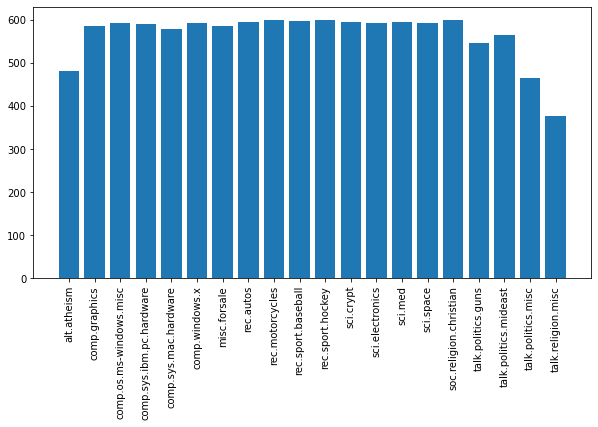

In [54]:
import numpy as np
np.random.seed(42)
import random
random.seed(42)

from matplotlib import pyplot as plt
from sklearn.datasets import fetch_20newsgroups

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [10,5]

twenty_plot = fetch_20newsgroups(subset='train')
labels = twenty_plot.target_names

y = list(range(20))
for i in range(20):
    y[i] = np.count_nonzero(twenty_plot.target == i)

matplotlib.pyplot.bar(labels,y)
plt.xticks(rotation=90)


C:\Users\Zoe\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Soft margin prediction stats:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      1560
           1       0.93      0.96      0.95      1590

    accuracy                           0.95      3150
   macro avg       0.95      0.94      0.95      3150
weighted avg       0.95      0.95      0.95      3150

Hard margin prediction stats:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1560
           1       0.96      0.97      0.97      1590

    accuracy                           0.96      3150
   macro avg       0.96      0.96      0.96      3150
weighted avg       0.96      0.96      0.96      3150



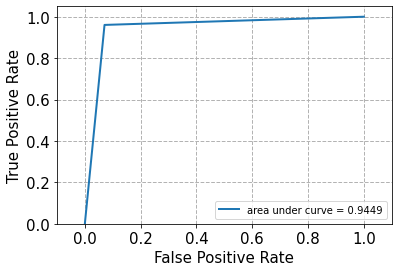

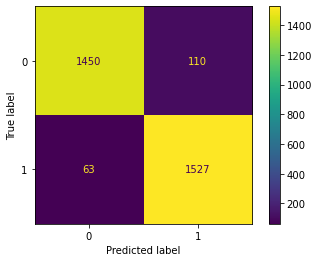

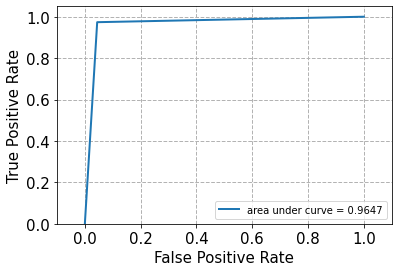

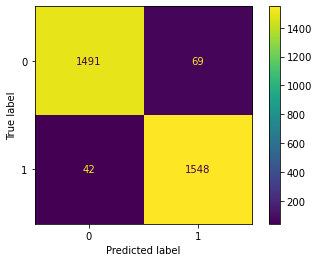

In [51]:
from sklearn.svm import LinearSVC
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import copy

categories = ['comp.graphics', 'comp.os.ms-windows.misc','comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware','rec.autos',
              'rec.motorcycles','rec.sport.baseball', 'rec.sport.hockey']

train_dataset = fetch_20newsgroups(subset = 'train', categories = categories,shuffle = True, random_state = None)
test_dataset  = fetch_20newsgroups(subset = 'test', categories = categories,shuffle = True, random_state = None)

train_dataset_bin = train_dataset.target.copy()
for i in range(len(train_dataset_bin)):
    if train_dataset.target[i] in [0,1,2,3]:
        train_dataset_bin[i] = 0
    else:
        train_dataset_bin[i] = 1
        
test_dataset_bin = test_dataset.target.copy()
for i in range(len(test_dataset_bin)):
    if test_dataset.target[i] in [0,1,2,3]:
        test_dataset_bin[i] = 0
    else:
        test_dataset_bin[i] = 1
    
count_vect = CountVectorizer(min_df=3, stop_words='english')
fitted_train = count_vect.fit_transform(train_dataset.data)
fitted_test = count_vect.transform(test_dataset.data)

soft_margin_SVC = LinearSVC(C=0.0001).fit(fitted_train, train_dataset_bin)
soft_margin_prediction = soft_margin_SVC.predict(fitted_test)
hard_margin_SVC = LinearSVC(C=1000).fit(fitted_train, train_dataset_bin)
hard_margin_prediction = hard_margin_SVC.predict(fitted_test)

fpr_soft, tpr_soft, thresholds_soft = metrics.roc_curve(test_dataset_bin, soft_margin_prediction, pos_label=1)
fpr_hard, tpr_hard, thresholds_hard = metrics.roc_curve(test_dataset_bin, hard_margin_prediction, pos_label=1)

def plot_roc(fpr, tpr):
    #I stole this from the discussion notebook!
    fig, ax = plt.subplots()

    roc_auc = metrics.auc(fpr,tpr)

    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)

    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)
        
plot_roc(fpr_soft,tpr_soft)
metrics.plot_confusion_matrix(soft_margin_SVC, fitted_test, test_dataset_bin)
print("Soft margin prediction stats:")
print(metrics.classification_report(test_dataset_bin,soft_margin_prediction))

plot_roc(fpr_hard,tpr_hard)
metrics.plot_confusion_matrix(hard_margin_SVC, fitted_test, test_dataset_bin)
print("Hard margin prediction stats:")
print(metrics.classification_report(test_dataset_bin,hard_margin_prediction))



